# Introduction #
### From First Project ###

We will use machine learning techniques to diagose pneumonia using images of x-rays.  Pneumonia is a condition in which fluid builds up in the lungs, typically caused by a virus or bacteria.  This is often diagnosed with a chest x-ray.  The appearance of white spots, called infiltrates, is part of the diagnosis.  https://www.radiologyinfo.org/en/info/pneumonia 

Chest x-rays are often done with the same or similar poses and posture with the sternum and spine centered.  People are generally considered closely proportioned.  If the x-rays are the same size, then there should be rough overlap of the sternal bones and the ribs which would appear white on the x-rays.  The differences would mostly appear in the empty space giving a large difference between an images diagnosed with pneumonia and images without a pneumonia diagnosis.  Because of the similarities of the images not diagnosed with pneumonia and similiarities of those with pneumonia, potentially appearing in clusters, $k$ nearest neighbors may be a viable approach.  Similarly, since there are only certain features that are being looked for, the infilitrates, we may be able to detect them numerically by looking at features such as average pixel shade, median pixel shade, number of dark, medium, and light pixels.  In this manner, a logistic regression may be useful.  Finally, rather than look at all the entire image, we could simply look at the location of the bright regions, in particular the location on the $x$-axis.  By looking at the average pixel brightness for each column, this could pick up locations with higher than normal brightness and be able to diagnose pneumonia.  Everyone would have bright columns where their sternum and spine are.  Since this is irrelevent to the diagnosis of pneumonia, a random forest ensemble could be useful.

Some complications may be a result of x-rays not being centered, the existence of people far from the typical proportion, different zoom level of x-rays, as well as the existence of other lung diseases (collapsed lung may have additional gray pixels, lesions or tumors may show as bright spots).

### New for Second Project ###

One of the difficulties with was with the images.  Even resized to a very small 100 by 250 pixel, this is 25000 pixels.  This contributes to a large dimension that is time consuming for methods like KNN and Logistic Regression.  PCA should make these results quicker, hopefully with minimal disruption in the accuracy.  A concern is finding the eigenvectors for a 25000x25000 matrix will be time consuming, but once it's complete, it should be easy to use by saving it and the eigenvalues in a csv file.

After running this through PCA, it should be quick to run these through KNN, Logisitic, and Random Forest again with different levels of explained variance to see if there were any changes.  We can then proceed to try clustering with the adjusted data set but not on the original since that would likely take a very long time to compute.

### New for Third Project ###

We can use Convolution Neural Networks since we are dealing with images.  One interesting choice is whether to use the same size picture, as we could use a larger picture size with different convolution size.  I will first start with the standard 100 by 250 pixels, then increase the size of the image.  As for the convolution size, it may need to be fairly small.  Pneumonia is "cloudy" which is hard to say if this is a result of very small changes or larger regions.  My non-medical thoughts is that the alveoli, which are tiny "air sacs" in the lungs are what's showing up in pneumonia x-rays.  Since these are small clusters, we would need a fine convolution.  Of course, different parts of lungs may be detectable, such as the five lobes.  The heart is often also visible, which may pose some difficulties.

I will also attempt to use a Recurrent Neural Network.  While not sequential data, we can make it sequential by our PCA from previously, using our coefficients of the eigenvectors as our input.  I am not convinced this is a proper use of RNN, I am also equally unconvinced that it is completely improper.  If this works, this could provide for faster training than CNN using less data.

Before starting, I expect CNN to be able to be tuned to at least as good as heirarchical clustering and possibly the best if the parameters can be tuned.

---

Imports the packages required

In [34]:
import scipy
from PIL import Image
from numpy import asarray
import csv
import numpy as np
import matplotlib.pylab as plt
from os import listdir
from os.path import isfile, join
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
import csv
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import random
import numpy.linalg as npl
from sklearn.neighbors import NearestCentroid
import keras
import tensorflow as tf
from tensorflow.keras import layers, models


In [35]:
keras.utils.set_random_seed(8675309)
tf.config.experimental.enable_op_determinism()

---

## Data Parsing ##

### Data set and parsing has not changed from the first project ###

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

The data set used is from Kaggle.  It is a variety of xray images of both pneumonia and normal conditions.  This is a large data set to download, but can be made into a csv file.

This is a selection from the images.  We need to convert the image into an array of pixel shades, 0 for black and 255 for white.  In this particular example, chosen from the data set, the picture is 1858 by 2090 pixels.

There are two major problems with the dataset as given.  It is too big; there are nearly 2 million pixels in this image.  Further, each image has a different number of pixels, so we must resize them to the same shape with a more managable size.  I chose 25000 pixels, although even that seems slow.  Converting the images to arrays takes approximately 15 minutes.  I wrote the dataset onto a comma delimited file, but it still takes about the same size, although the file is more compact in size and arrangement.

First 1341 are normal, last 3875 are pneumonia for 5216 total xrays in the training data set.

In [36]:
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

# Create list of files in the directories in the data training set
# The downloaded file set should be set into the same folder as this file.


normalfiles = [f for f in listdir('./chest_xray/train/NORMAL') if isfile(join('./chest_xray/train/NORMAL',f))]
pneumfiles = [f for f in listdir('./chest_xray/train/PNEUMONIA') if isfile(join('./chest_xray/train/PNEUMONIA',f))]

This section commented off in favor of csv file.  Originally took 15 minutes until I realized that allocating the right amount of memory ahead of time is a lot faster.  Down to about 1 minute

Here we go through each folder that contains the normal and pneumonia xray images.  This starts off being a 3 dimensional array, 2 dimension being that of the image and the third being the index of the images.  The images need to be flattened into a one dimensional array for a total of two dimensions to work with the KNN algorithm.  The normal x-rays have a $y$ value of 0 and pneumonia has a $y$ value of 1.  Since the normal images were loaded first, 

Some of the files in the pneumonia files were not completely black and white and had RGB layers.  These had to be stripped off to a single layer.

Uncomment to use the images in the folder.

Note: .reshape() and .resize() are transposed from each other!

In [37]:
'''

import numpy as np

# Reads each image in training files that is "normal", resizes it, adds it to the list
imgTrain = np.empty([5216,100,250])
yTrain = np.empty([5216])
n=0
for i in normalfiles:
    fileStr = './chest_xray/train/NORMAL/'+i
    img = Image.open(fileStr)
    img = img.resize((250,100))
    numpydata = asarray(img)
    imgTrain[n] = numpydata
    yTrain[n] = 0
    n+=1
print(n)
print(imgTrain.shape)
    


# Repeats for pneumonia images

for i in pneumfiles:

    fileStr = './chest_xray/train/PNEUMONIA/'+i
    img = Image.open(fileStr)
    img = img.resize((250,100))
    numpydata = asarray(img)

    # Some are RGB 3 dimensional arrays, use only the 2 dimension
    if numpydata.ndim == 3:
        numpydata = numpydata[:,:,0]
    imgTrain[n] = numpydata
    yTrain[n] = 1
    n+=1

print(n)
print(imgTrain.shape)

imgTrain = imgTrain.reshape(-1,25000)



'''


'\n\nimport numpy as np\n\n# Reads each image in training files that is "normal", resizes it, adds it to the list\nimgTrain = np.empty([5216,100,250])\nyTrain = np.empty([5216])\nn=0\nfor i in normalfiles:\n    fileStr = \'./chest_xray/train/NORMAL/\'+i\n    img = Image.open(fileStr)\n    img = img.resize((250,100))\n    numpydata = asarray(img)\n    imgTrain[n] = numpydata\n    yTrain[n] = 0\n    n+=1\nprint(n)\nprint(imgTrain.shape)\n    \n\n\n# Repeats for pneumonia images\n\nfor i in pneumfiles:\n\n    fileStr = \'./chest_xray/train/PNEUMONIA/\'+i\n    img = Image.open(fileStr)\n    img = img.resize((250,100))\n    numpydata = asarray(img)\n\n    # Some are RGB 3 dimensional arrays, use only the 2 dimension\n    if numpydata.ndim == 3:\n        numpydata = numpydata[:,:,0]\n    imgTrain[n] = numpydata\n    yTrain[n] = 1\n    n+=1\n\nprint(n)\nprint(imgTrain.shape)\n\nimgTrain = imgTrain.reshape(-1,25000)\n\n\n\n'

This turned the image files into a csv file, writing the imgTrain array to traindata.csv  This did not save time as I had hoped, but it does save memory compared to the raw image files.

Uncomment to write a new csv.

In [38]:
'''
import csv

with open('traindata.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(imgTrain)
    '''

"\nimport csv\n\nwith open('traindata.csv', 'w', newline='') as file:\n    writer = csv.writer(file)\n    writer.writerows(imgTrain)\n    "

A good bit quicker and only csv file needed.  Without proper memory allocation, took about the same time.

In [39]:

yTrain = np.zeros(1341)
yTrain = np.append(yTrain,np.ones(3875))
imgTrain = np.empty((5216,25000))
with open('traindata.csv', 'r') as file:
    readFile = csv.reader(file)
    idx = 0
    for line in readFile:

        # imgTrain[idx] = np.array(line, dtype=float)
        imgTrain[idx] = np.array(line, dtype=float)
        idx += 1


This allows you to pull out an image from the training data to see it.  Uncomment and set the index $n$ should be between 0 and 5215.

In [40]:
'''n=0
checkImage = Image.fromarray(imgTrain[n].reshape([100,250]))
checkImage.show()'''

'n=0\ncheckImage = Image.fromarray(imgTrain[n].reshape([100,250]))\ncheckImage.show()'

Some verification that each image in the training has a correspoding diagnosis.

In [41]:
print('Number of pictures and number of pixels per picture')
print(imgTrain.shape)
print('Number of diagnoses (Negative and Positive)')
print(yTrain.size)


Number of pictures and number of pixels per picture
(5216, 25000)
Number of diagnoses (Negative and Positive)
5216


Now to parse the test data in the same way as the training data.

Uncomment to use image files.

In [42]:
'''
normalfiles = [f for f in listdir('./chest_xray/test/NORMAL') if isfile(join('./chest_xray/test/NORMAL',f))]
pneumfiles = [f for f in listdir('./chest_xray/test/PNEUMONIA') if isfile(join('./chest_xray/test/PNEUMONIA',f))]


imgTest = np.empty([0,100,250])
yTest = np.array([])
n=0
for i in normalfiles:
    fileStr = './chest_xray/test/NORMAL/'+i
    img = Image.open(fileStr)
    img = img.resize((250,100))
    numpydata = asarray(img)
    imgTest = np.append(imgTest,[numpydata], axis=0)
    yTest = np.append(yTest,0)
    n+=1
print(n)
print(imgTest.shape)
    


# Repeats for pneumonia images
n=0
for i in pneumfiles:

    fileStr = './chest_xray/test/PNEUMONIA/'+i
    img = Image.open(fileStr)
    img = img.resize((250,100))
    numpydata = asarray(img)

    # Some are RGB 3 dimensional arrays, use only the 2 dimension
    if numpydata.ndim == 3:
        numpydata = numpydata[:,:,0]
    imgTest = np.append(imgTest,[numpydata], axis=0)
    yTest = np.append(yTest,1)
    n+=1

print(n)
print(imgTest.shape)

imgTest = imgTest.reshape(-1,25000)

'''

"\nnormalfiles = [f for f in listdir('./chest_xray/test/NORMAL') if isfile(join('./chest_xray/test/NORMAL',f))]\npneumfiles = [f for f in listdir('./chest_xray/test/PNEUMONIA') if isfile(join('./chest_xray/test/PNEUMONIA',f))]\n\n\nimgTest = np.empty([0,100,250])\nyTest = np.array([])\nn=0\nfor i in normalfiles:\n    fileStr = './chest_xray/test/NORMAL/'+i\n    img = Image.open(fileStr)\n    img = img.resize((250,100))\n    numpydata = asarray(img)\n    imgTest = np.append(imgTest,[numpydata], axis=0)\n    yTest = np.append(yTest,0)\n    n+=1\nprint(n)\nprint(imgTest.shape)\n    \n\n\n# Repeats for pneumonia images\nn=0\nfor i in pneumfiles:\n\n    fileStr = './chest_xray/test/PNEUMONIA/'+i\n    img = Image.open(fileStr)\n    img = img.resize((250,100))\n    numpydata = asarray(img)\n\n    # Some are RGB 3 dimensional arrays, use only the 2 dimension\n    if numpydata.ndim == 3:\n        numpydata = numpydata[:,:,0]\n    imgTest = np.append(imgTest,[numpydata], axis=0)\n    yTest = np.

Again, I wrote it to a comma delimited file and instead can read just the file.  This one is much faster in both reading the csv and in reading the images compared to the training data set since it is much smaller.

Uncomment to write a new csv file.

In [43]:
'''
import csv

with open('testdata.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(imgTest)
    '''

"\nimport csv\n\nwith open('testdata.csv', 'w', newline='') as file:\n    writer = csv.writer(file)\n    writer.writerows(imgTest)\n    "

In [44]:
yTest = np.zeros(234)
yTest = np.append(yTest,np.ones(390))
imgTest = np.empty([624,25000])
idx = 0
with open('testdata.csv', 'r') as file:
    readFile = csv.reader(file)
    for line in readFile:
        imgTest[idx] = np.array(line, dtype=float)
        idx+=1


This allows us to check an image from the dataset.  Here $n$ is between 0 and 623.

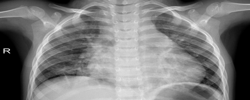

In [45]:

n=623
checkImage = Image.fromarray(imgTest[n].reshape([100,250]))
checkImage = checkImage.convert(mode='L')
checkImage

---

Using https://www.tensorflow.org/tutorials/images/cnn as a guide

In [46]:
yTrain = np.array(yTrain,dtype = int)
yTest = np.array(yTest, dtype = int)
# Requires int labels, not float

imgTrain = imgTrain.reshape([5216,100,250,1])
imgTest = imgTest.reshape([624,100,250,1])
# Changing shape

(train_images, train_labels), (test_images, test_labels) = (imgTrain, yTrain), (imgTest, yTest)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [47]:
train_labels.shape[0]

5216

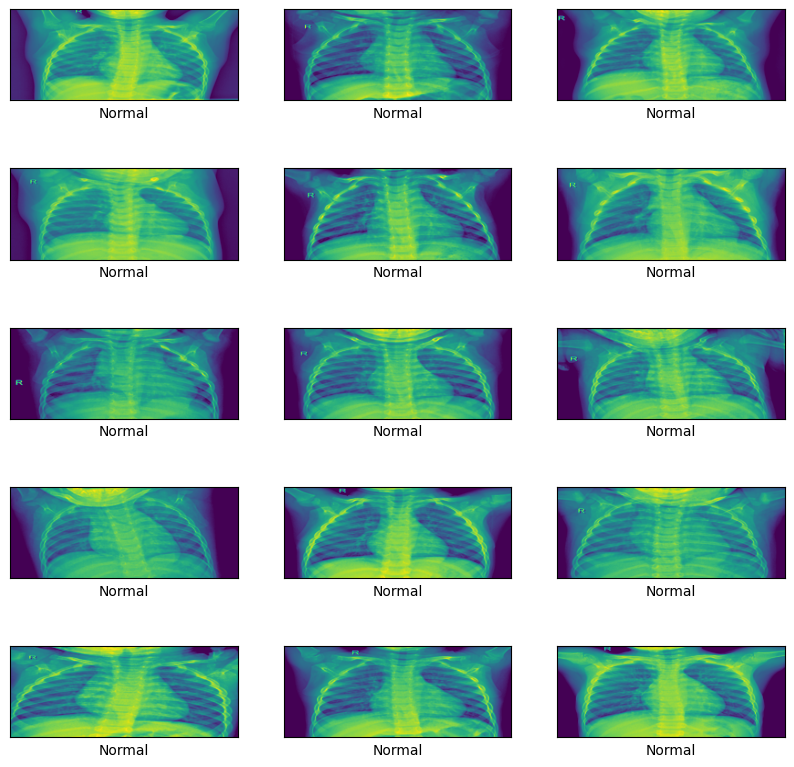

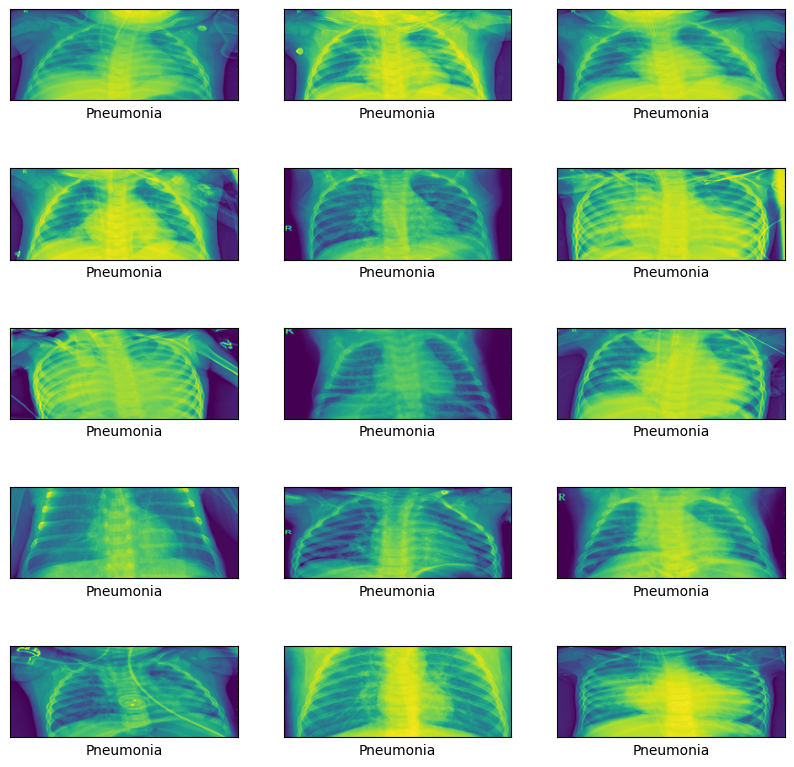

In [48]:
class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[train_images.shape[0]-i-1])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[train_labels.shape[0]-i-1]])
plt.show()

---

### First CNN Model
The first CNN model is mostly general and copied from the website, having 3x3 convlutions and average poolings in between.  This gives over 5 million trainable parameters, which I suspect will overtrain the model.

In [49]:
# Compare Average vs Max Pooling!

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [50]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 98, 248, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 49, 124, 32)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 47, 122, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 23, 61, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 21, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 79296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     5,075,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,130,882 (19.57 MB)

 Trainable params: 5,130,882 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 5 minutes


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.8627 - loss: 0.2960 - val_accuracy: 0.7340 - val_loss: 0.7828
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9541 - loss: 0.1217 - val_accuracy: 0.8285 - val_loss: 0.5224
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.9610 - loss: 0.1035 - val_accuracy: 0.7612 - val_loss: 1.3601
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9665 - loss: 0.0783 - val_accuracy: 0.7997 - val_loss: 0.6260
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.9770 - loss: 0.0640 - val_accuracy: 0.7885 - val_loss: 0.8174
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9761 - loss: 0.0762 - val_accuracy: 0.7965 - val_loss: 0.7559
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9793 - loss: 0.0598 - val_accuracy: 0.7804 - val_loss: 0.9972
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9842 - loss: 0.0479 - val

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

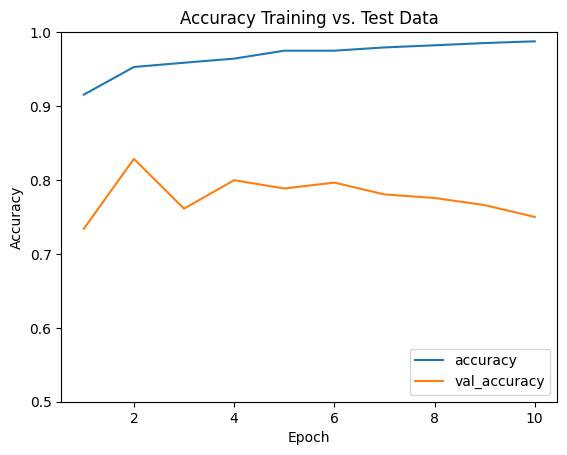

In [52]:
plt.plot(np.arange(10)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(10)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")



Text(0.5, 1.0, 'Loss Training vs. Test Data')

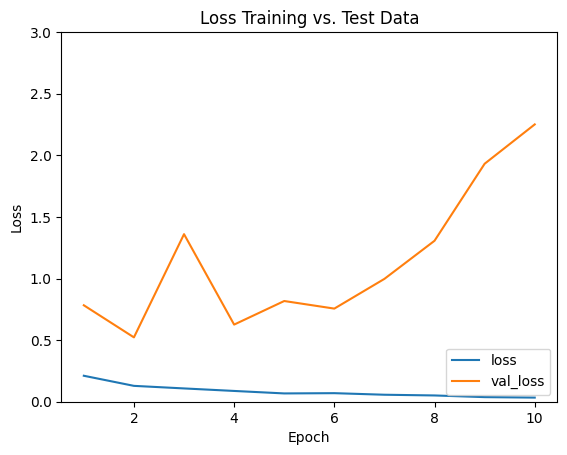

In [53]:
plt.plot(np.arange(10)+1,history.history['loss'], label='loss')
plt.plot(np.arange(10)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")



From above, we can see that we can stop the training early at epoch 3 for the best results.  It has a slightly higher loss than epoch 1, but a better accuracy on both testing and training data.  Stopping early may be useful if this architecture is used.

---

### Model 2
Now I will replace average pooling with max pooling to see if the results are better or worse.  I don't know what to expect.

In [54]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))






Epoch 1/10


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - accuracy: 0.8550 - loss: 0.3490 - val_accuracy: 0.8141 - val_loss: 0.4701
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.9558 - loss: 0.1046 - val_accuracy: 0.8061 - val_loss: 0.5785
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.9704 - loss: 0.0769 - val_accuracy: 0.8221 - val_loss: 0.6094
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.9692 - loss: 0.0711 - val_accuracy: 0.7660 - val_loss: 0.8936
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.9756 - loss: 0.0624 - val_accuracy: 0.8141 - val_loss: 0.7889
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.9878 - loss: 0.0356 - val_accuracy: 0.8173 - val_loss: 0.7867
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9847 - loss: 0.0416 - val_accuracy: 0.8029 - val_loss: 1.3869
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.9900 - loss: 0.0279 - val

Text(0.5, 1.0, 'Accuracy Training vs. Test Data using MaxPooling')

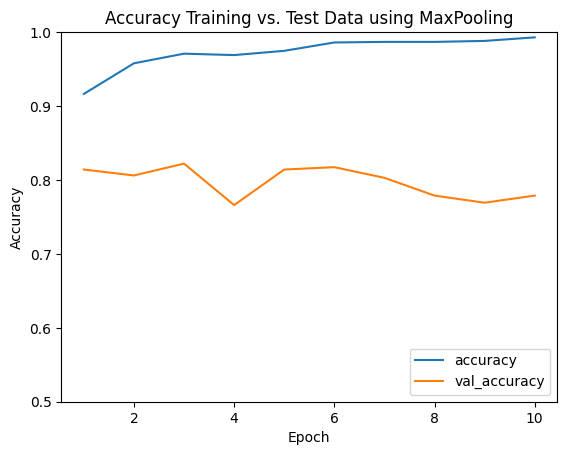

In [55]:
plt.plot(np.arange(10)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(10)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data using MaxPooling")



Text(0.5, 1.0, 'Loss Training vs. Test Data using MaxPooling')

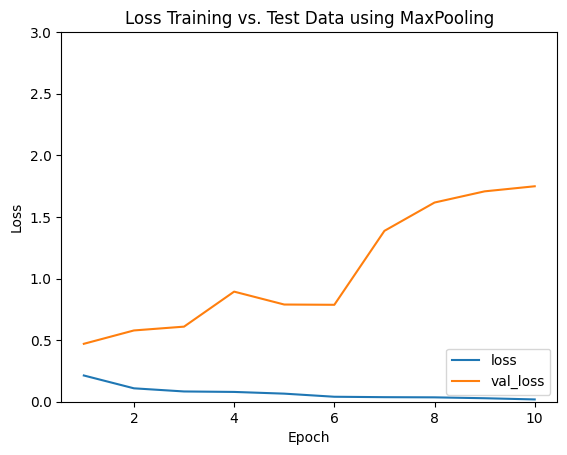

In [56]:
plt.plot(np.arange(10)+1,history.history['loss'], label='loss')
plt.plot(np.arange(10)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data using MaxPooling")



Here, the accuracy is best in the first epoch, which sometimes happens when the other one is run as well.  We can see that by epoch 10, the test accuracy decreases and the loss increases significantly.   I wonder if reducing the learning rate will help.

---

## Tuning the learning rate

In [57]:
model = None
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(2))

model1.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - accuracy: 0.7570 - loss: 0.4848 - val_accuracy: 0.7821 - val_loss: 0.4493
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9312 - loss: 0.2536 - val_accuracy: 0.7788 - val_loss: 0.5137
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9552 - loss: 0.2257 - val_accuracy: 0.7708 - val_loss: 0.5418
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9555 - loss: 0.2135 - val_accuracy: 0.7853 - val_loss: 0.6009
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9642 - loss: 0.2045 - val_accuracy: 0.7837 - val_loss: 0.7101
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9686 - loss: 0.1946 - val_accuracy: 0.7772 - val_loss: 0.7211
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9724 - loss: 0.1872 - val_accuracy: 0.7612 - val_loss: 0.8167
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9726 - loss: 0.1825 - val

In [58]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(2))

model2.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.7798 - loss: 0.4866 - val_accuracy: 0.7724 - val_loss: 0.4335
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9361 - loss: 0.1854 - val_accuracy: 0.8269 - val_loss: 0.3791
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9527 - loss: 0.1250 - val_accuracy: 0.7869 - val_loss: 0.4730
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9575 - loss: 0.1103 - val_accuracy: 0.7965 - val_loss: 0.4812
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9607 - loss: 0.1016 - val_accuracy: 0.7901 - val_loss: 0.5289
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9678 - loss: 0.0892 - val_accuracy: 0.7885 - val_loss: 0.5930
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9729 - loss: 0.0793 - val_accuracy: 0.7885 - val_loss: 0.6231
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9749 - loss: 0

In [60]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(2))

model3.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = model3.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.7521 - loss: 0.5772 - val_accuracy: 0.6250 - val_loss: 0.6279
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.7706 - loss: 0.4333 - val_accuracy: 0.6554 - val_loss: 0.5561
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.8932 - loss: 0.2999 - val_accuracy: 0.7580 - val_loss: 0.4459
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9376 - loss: 0.2003 - val_accuracy: 0.7692 - val_loss: 0.4310
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9455 - loss: 0.1607 - val_accuracy: 0.7756 - val_loss: 0.4386
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9508 - loss: 0.1394 - val_accuracy: 0.7660 - val_loss: 0.4546
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.9548 - loss: 0.1257 - val_accuracy: 0.7724 - val_loss: 0.4754
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9597 - loss: 0

In [61]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(2))

model4.compile(optimizer=keras.optimizers.Adam(0.000005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history4 = model4.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.7380 - loss: 0.5769 - val_accuracy: 0.6250 - val_loss: 0.6494
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.7537 - loss: 0.4899 - val_accuracy: 0.6410 - val_loss: 0.5533
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.8162 - loss: 0.3921 - val_accuracy: 0.7179 - val_loss: 0.4878
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.8972 - loss: 0.3048 - val_accuracy: 0.7596 - val_loss: 0.4477
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.9182 - loss: 0.2483 - val_accuracy: 0.7740 - val_loss: 0.4269
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.9296 - loss: 0.2120 - val_accuracy: 0.7772 - val_loss: 0.4169
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.9385 - loss: 0.1863 - val_accuracy: 0.7853 - val_loss: 0.4140
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.9438 - loss: 0

In [62]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 250, 1)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(2))

model5.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history5 = model5.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.7258 - loss: 0.6269 - val_accuracy: 0.6250 - val_loss: 0.6824
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.7521 - loss: 0.5537 - val_accuracy: 0.6250 - val_loss: 0.6740
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.7521 - loss: 0.5359 - val_accuracy: 0.6250 - val_loss: 0.6591
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.7521 - loss: 0.5175 - val_accuracy: 0.6250 - val_loss: 0.6423
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.7521 - loss: 0.4972 - val_accuracy: 0.6250 - val_loss: 0.6243
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.7521 - loss: 0.4757 - val_accuracy: 0.6250 - val_loss: 0.6061
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.7551 - loss: 0.4539 - val_accuracy: 0.6250 - val_loss: 0.5876
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.7734 - loss: 0

Text(0.5, 1.0, 'Loss on Test Data for Different Learning Rates')

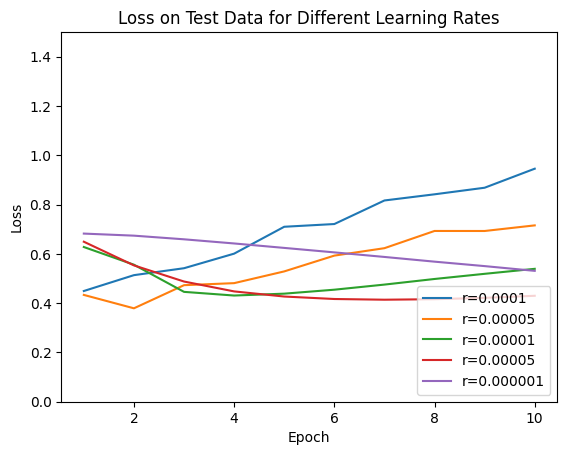

In [65]:
plt.plot(np.arange(10)+1,history1.history['val_loss'], label = 'r=0.0001')
plt.plot(np.arange(10)+1,history2.history['val_loss'], label = 'r=0.00005')
plt.plot(np.arange(10)+1,history3.history['val_loss'], label = 'r=0.00001')
plt.plot(np.arange(10)+1,history4.history['val_loss'], label = 'r=0.00005')
plt.plot(np.arange(10)+1,history5.history['val_loss'], label = 'r=0.000001')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.legend(loc='lower right')
plt.title("Loss on Test Data for Different Learning Rates")

Text(0.5, 1.0, 'Accuracy on Test Data for Different Learning Rates')

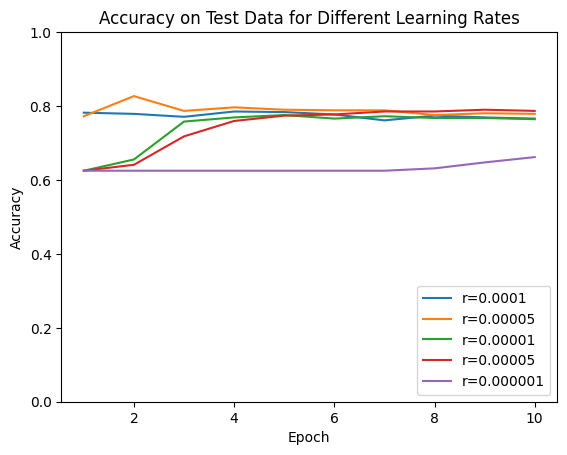

In [66]:
plt.plot(np.arange(10)+1,history1.history['val_accuracy'], label = 'r=0.0001')
plt.plot(np.arange(10)+1,history2.history['val_accuracy'], label = 'r=0.00005')
plt.plot(np.arange(10)+1,history3.history['val_accuracy'], label = 'r=0.00001')
plt.plot(np.arange(10)+1,history4.history['val_accuracy'], label = 'r=0.00005')
plt.plot(np.arange(10)+1,history5.history['val_accuracy'], label = 'r=0.000001')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Accuracy on Test Data for Different Learning Rates")

We can see that having a lower learning rate smooths out the accuracy of the testing data.  Although the accuracy is a bit lower, it seems more predictable and well behaved, although with a learning rate of 0.00005, I may want to extend to more than 10 epochs.  A learning rate 0.000001 seems too low, although potentially interesting.  The accuracy in the test data of 0.6250 tells me that it's predicting everything as being diagnosed with pneumonia and then it is slowly changing some diagnoses at each step.

---

## Convolution sizes
Now I will try various convolution sizes.  The first I will take a larger snapshot of the lungs, each lobe I'd guess to be about 20 by 50 pixels in the resized image.

In [82]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32, (20, 50), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 81, 201, 32)    │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 520992)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │    16,671,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,703,874 (63.72 MB)

 Trainable params: 16,703,874 (63.72 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(optimizer=keras.optimizers.Adam(0.000005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=25, 
                    validation_data=(test_images, test_labels))

Epoch 1/25
 90/163 ━━━━━━━━━━━━━━━━━━━━ 32s 450ms/step - accuracy: 0.7743 - loss: 0.4926

163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.8015 - loss: 0.4399 - val_accuracy: 0.7933 - val_loss: 0.4060
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - accuracy: 0.9254 - loss: 0.1984 - val_accuracy: 0.7869 - val_loss: 0.4404
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - accuracy: 0.9408 - loss: 0.1588 - val_accuracy: 0.7853 - val_loss: 0.4858
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.9456 - loss: 0.1464 - val_accuracy: 0.7853 - val_loss: 0.5288
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.9482 - loss: 0.1361 - val_accuracy: 0.7788 - val_loss: 0.5875
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.9530 - loss: 0.1274 - val_accuracy: 0.7692 - val_loss: 0.6278
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.9570 - loss: 0.1210 - val_accuracy: 0.7660 - val_loss: 0.6593
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - accuracy: 0.9581 - loss: 0.1159 - val

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

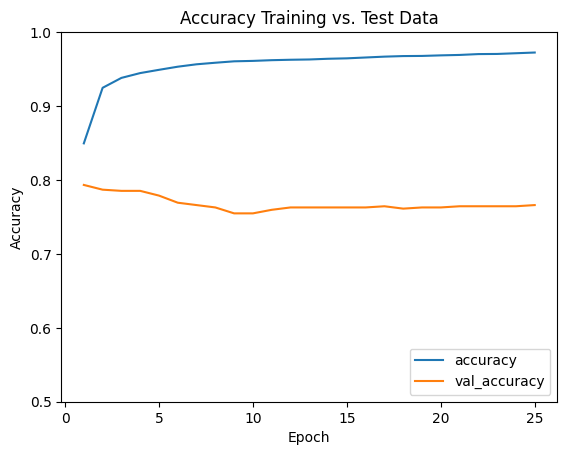

In [84]:
plt.plot(np.arange(25)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(25)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")


Text(0.5, 1.0, 'Loss Training vs. Test Data')

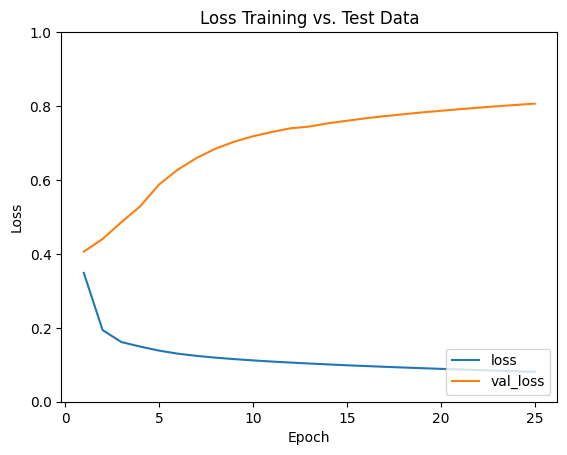

In [85]:
plt.plot(np.arange(25)+1,history.history['loss'], label='loss')
plt.plot(np.arange(25)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")


This one is a first here, the validation decreases while the accuracy also decreases at one point.  This is telling me around epoch 18, there are many that go back and forth in the diagnosis and could be as good as the model could get.  Going to an extreme, I will have it do a 1x1 convolution, which will look at every pixel individually.  I expect a long time for this to be tedious and looks memory intensive, and overfit quickly, even with a low learning rate.  However, changing the number of copies to 8 from 32 significantly increases speed and lowers memeory requirements, even lowering the overfitting.  However, with 1.6 million trainable parameters, there is likely to be overfitting.

In [86]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(8, (1, 1), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))
model.summary()



Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 100, 250, 8)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │     1,600,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,042 (6.10 MB)

 Trainable params: 1,600,042 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(optimizer=keras.optimizers.Adam(0.000005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=25, 
                    validation_data=(test_images, test_labels))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7521 - loss: 0.5614

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7521 - loss: 0.5613 - val_accuracy: 0.6250 - val_loss: 0.6321
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7521 - loss: 0.4685 - val_accuracy: 0.6250 - val_loss: 0.5527
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8016 - loss: 0.3799 - val_accuracy: 0.6603 - val_loss: 0.5332
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8370 - loss: 0.3459 - val_accuracy: 0.6731 - val_loss: 0.5209
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8588 - loss: 0.3277 - val_accuracy: 0.6811 - val_loss: 0.5192
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8742 - loss: 0.3153 - val_accuracy: 0.6875 - val_loss: 0.5174
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8860 - loss: 0.3057 - val_accuracy: 0.6939 - val_loss: 0.5198
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8922 - loss: 0.2980 - val_accuracy: 0.693

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

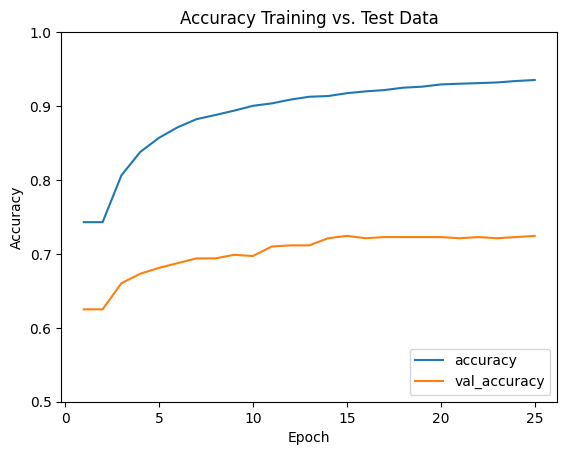

In [88]:
plt.plot(np.arange(25)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(25)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

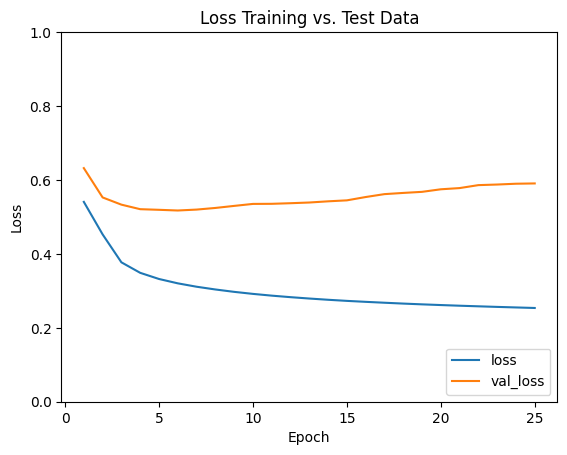

In [89]:
plt.plot(np.arange(25)+1,history.history['loss'], label='loss')
plt.plot(np.arange(25)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

Now I will try a single smaller convolution layer, 3x5.  This should capture some of the finer detail, but not be so much as the 1x1.  Combined with a pooling layer, this should further cut down on memory and features.

In [90]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32,(3,5), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 98, 246, 32)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 771456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │    24,686,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,687,202 (94.17 MB)

 Trainable params: 24,687,202 (94.17 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(optimizer=keras.optimizers.Adam(0.000005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=25, 
                    validation_data=(test_images, test_labels))

Epoch 1/25
157/163 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.7524 - loss: 0.5779

163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.7521 - loss: 0.5776 - val_accuracy: 0.6250 - val_loss: 0.6571
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7521 - loss: 0.5412 - val_accuracy: 0.6250 - val_loss: 0.6512
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7521 - loss: 0.5182 - val_accuracy: 0.6250 - val_loss: 0.6368
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.7521 - loss: 0.4948 - val_accuracy: 0.6250 - val_loss: 0.6159
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7540 - loss: 0.4688 - val_accuracy: 0.6250 - val_loss: 0.5886
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7753 - loss: 0.4390 - val_accuracy: 0.6346 - val_loss: 0.5608
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.8177 - loss: 0.4052 - val_accuracy: 0.6923 - val_loss: 0.5145
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.8639 - loss: 0.3603 - val

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

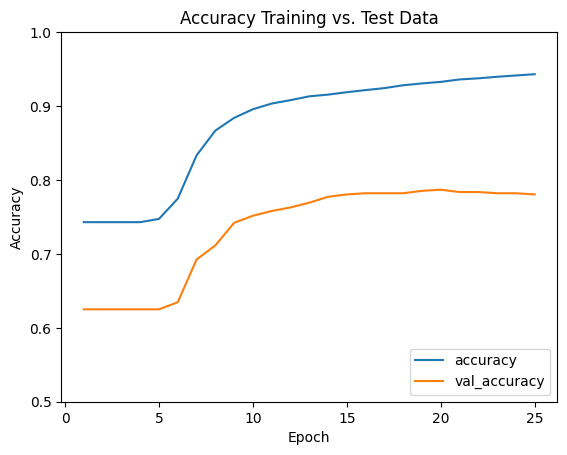

In [95]:
plt.plot(np.arange(25)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(25)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

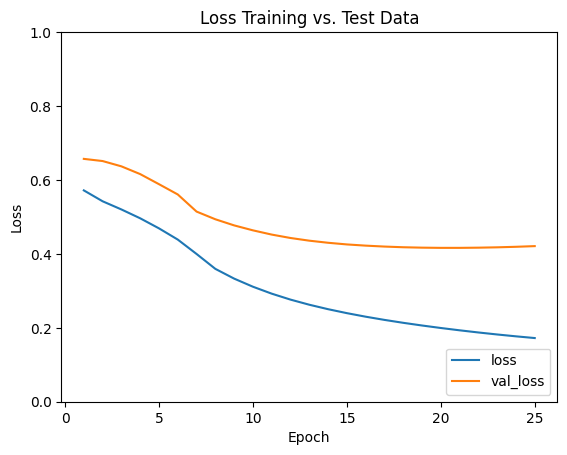

In [96]:
plt.plot(np.arange(25)+1,history.history['loss'], label='loss')
plt.plot(np.arange(25)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

This one is fast and fits relatively well as any of them without luck.  So I will try stacking filters, a small and a large in different orders.

---

## Combining layers

In [97]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32,(3,5), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.MaxPooling2D(2,4))
model.add(layers.Conv2D(32, (20, 50), activation='relu'))
model.add(layers.MaxPooling2D(6,13))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 98, 246, 32)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 25, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 6, 13, 32)      │     1,024,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025,666 (3.91 MB)

 Trainable params: 1,025,666 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
model.compile(optimizer=keras.optimizers.Adam(0.000005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=25, 
                    validation_data=(test_images, test_labels))

Epoch 1/25
 34/163 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.5995 - loss: 0.6710

163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7016 - loss: 0.6193 - val_accuracy: 0.6250 - val_loss: 0.6659
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7521 - loss: 0.5346 - val_accuracy: 0.6250 - val_loss: 0.6355
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7521 - loss: 0.4981 - val_accuracy: 0.6250 - val_loss: 0.5943
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7578 - loss: 0.4559 - val_accuracy: 0.6250 - val_loss: 0.5592
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.7885 - loss: 0.4172 - val_accuracy: 0.6651 - val_loss: 0.5282
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8291 - loss: 0.3840 - val_accuracy: 0.6939 - val_loss: 0.5015
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8500 - loss: 0.3549 - val_accuracy: 0.7276 - val_loss: 0.4796
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8744 - loss: 0.3301 - val

The loss here is lowest around epoch 22, and the highest accuracy is epoch 24 with an accuracy considtently above 80%.  This looks to be a good model, the best one able to be attained so far without chance.

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

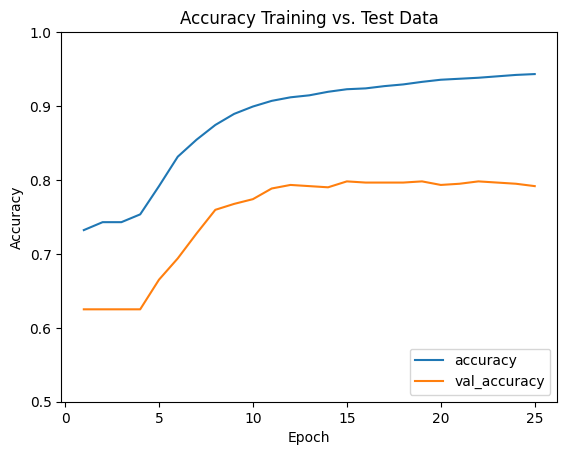

In [99]:
plt.plot(np.arange(25)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(25)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")


Text(0.5, 1.0, 'Loss Training vs. Test Data')

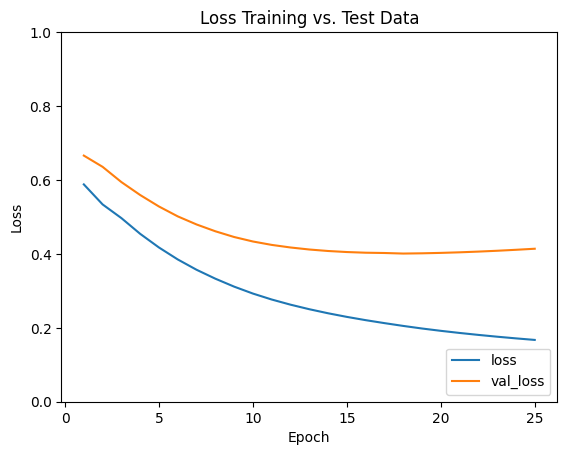

In [100]:
plt.plot(np.arange(25)+1,history.history['loss'], label='loss')
plt.plot(np.arange(25)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

Stacking several smaller convolutions with max polling between.  This has fewer features, only just above 19000.  There may be several convolutions, they are each small.  The convergence was very slow, so the learning rate was increased.  This still was improving after 25 epochs, so that was also increased significantly.  I wanted to keep the learning rate low, perhaps too low.

In [101]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32,(3,5), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.MaxPooling2D(3,5))
model.add(layers.Conv2D(32,(2,5), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.MaxPooling2D(2,5))
model.add(layers.Conv2D(32,(2,3), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.MaxPooling2D(2,3))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 98, 246, 32)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 20, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 19, 45, 32)     │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 4, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 3, 7, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,106 (74.63 KB)

 Trainable params: 19,106 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels))

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7521 - loss: 0.6471 - val_accuracy: 0.6250 - val_loss: 0.6679
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7521 - loss: 0.6087 - val_accuracy: 0.6250 - val_loss: 0.6700
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7521 - loss: 0.5804 - val_accuracy: 0.6250 - val_loss: 0.6809
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7521 - loss: 0.5664 - val_accuracy: 0.6250 - val_loss: 0.6891
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7521 - loss: 0.5601 - val_accuracy: 0.6250 - val_loss: 0.6903
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7521 - loss: 0.5552 - val_accuracy: 0.6250 - val_loss: 0.6891
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7521 - loss: 0.5510 - val_accuracy: 0.6250 - val_loss: 0.6875
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7521 - loss: 0

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

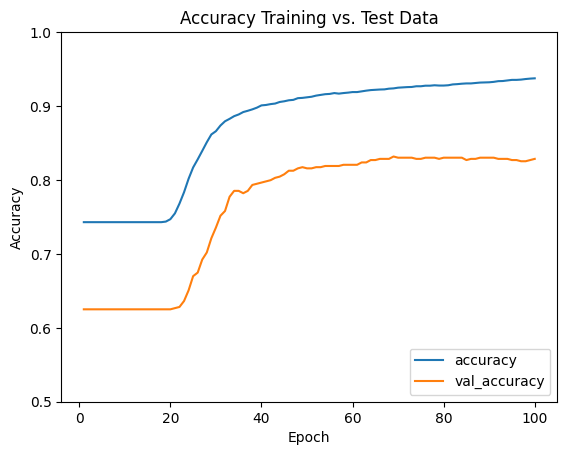

In [103]:
plt.plot(np.arange(100)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(100)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

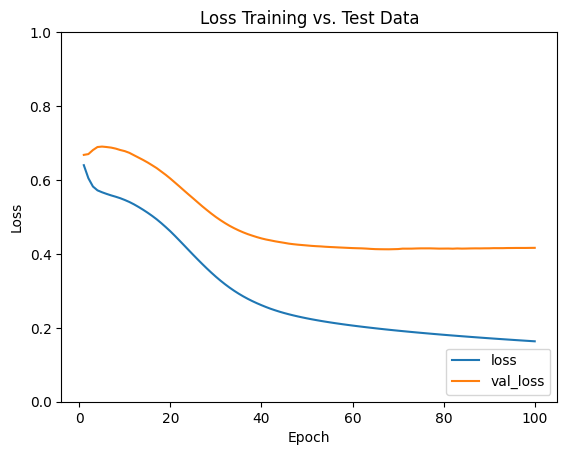

In [104]:
plt.plot(np.arange(100)+1,history.history['loss'], label='loss')
plt.plot(np.arange(100)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

This one is very slow, but has remarkable accuracy, maxing out at nearly 84%.

---

### Dropout layers
Adding dropout layers here to see if we can increase the performance of our so far best model.  Here, I will add a 5% drop rate after each convolution layer.

In [105]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32,(3,5), activation='relu', input_shape=(100, 250, 1)))
model.add(layers.Dropout(0.05))
model.add(layers.MaxPooling2D(3,5))
model.add(layers.Conv2D(32,(2,5), activation='relu'))
model.add(layers.Dropout(0.05))
model.add(layers.MaxPooling2D(2,5))
model.add(layers.Conv2D(32,(2,3), activation='relu'))
model.add(layers.Dropout(0.05))
model.add(layers.MaxPooling2D(2,3))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 98, 246, 32)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 246, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 20, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 19, 45, 32)     │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 4, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 3, 7, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,106 (74.63 KB)

 Trainable params: 19,106 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels))

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.4641 - loss: 0.6934 - val_accuracy: 0.6250 - val_loss: 0.6838
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.6638 - val_accuracy: 0.6250 - val_loss: 0.6759
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.6398 - val_accuracy: 0.6250 - val_loss: 0.6690
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.6128 - val_accuracy: 0.6250 - val_loss: 0.6659
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.5884 - val_accuracy: 0.6250 - val_loss: 0.6687
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.5720 - val_accuracy: 0.6250 - val_loss: 0.6712
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 - loss: 0.5619 - val_accuracy: 0.6250 - val_loss: 0.6735
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7521 -

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

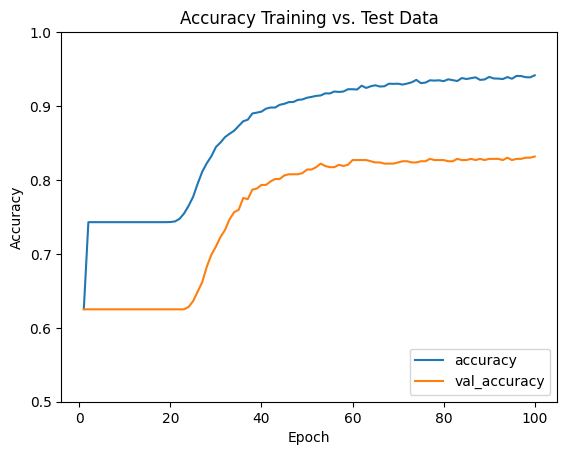

In [107]:
plt.plot(np.arange(100)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(100)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

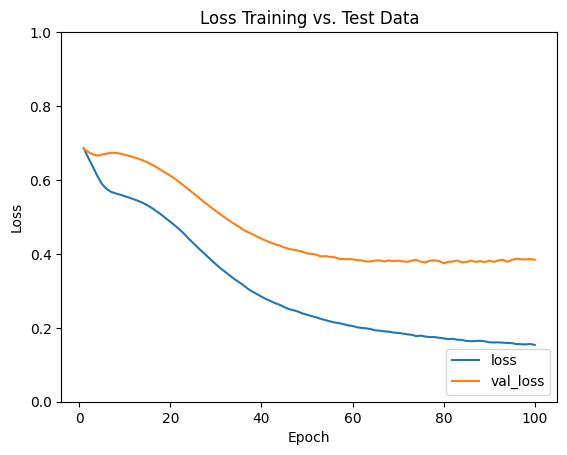

In [108]:
plt.plot(np.arange(100)+1,history.history['loss'], label='loss')
plt.plot(np.arange(100)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

In [114]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32,(3,5), activation='relu', input_shape=(100, 250, 1)))

model.add(layers.MaxPooling2D(3,5))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(32,(2,5), activation='relu'))

model.add(layers.MaxPooling2D(2,5))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(32,(2,3), activation='relu'))

model.add(layers.MaxPooling2D(2,3))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 98, 246, 32)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 20, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 19, 45, 32)     │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 4, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 3, 7, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,106 (74.63 KB)

 Trainable params: 19,106 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Since the dropout rate should help avoid overfitting, I increased the learning rate again.  Here, the number of epochs was lowered since the convergence seems to be fairly quick.  This leads me to think I can increase the drop rate more, possibly add more copies.  Here I get a comparable accuaracy and loss to the slower learning rate, but a good bit faster overall.

In [115]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=30, 
                    validation_data=(test_images, test_labels))

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.7479 - loss: 0.6294 - val_accuracy: 0.6250 - val_loss: 0.6794
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7521 - loss: 0.5665 - val_accuracy: 0.6250 - val_loss: 0.6757
Epoch 3/30
 48/163 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7618 - loss: 0.5530

163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7521 - loss: 0.5614 - val_accuracy: 0.6250 - val_loss: 0.6682
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7521 - loss: 0.5573 - val_accuracy: 0.6250 - val_loss: 0.6608
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7521 - loss: 0.5485 - val_accuracy: 0.6250 - val_loss: 0.6475
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7521 - loss: 0.5398 - val_accuracy: 0.6250 - val_loss: 0.6308
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7522 - loss: 0.5273 - val_accuracy: 0.6250 - val_loss: 0.5962
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7587 - loss: 0.4949 - val_accuracy: 0.6635 - val_loss: 0.5555
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7701 - loss: 0.4728 - val_accuracy: 0.7196 - val_loss: 0.5141
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8038 - loss: 0.4313 - val_accura

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

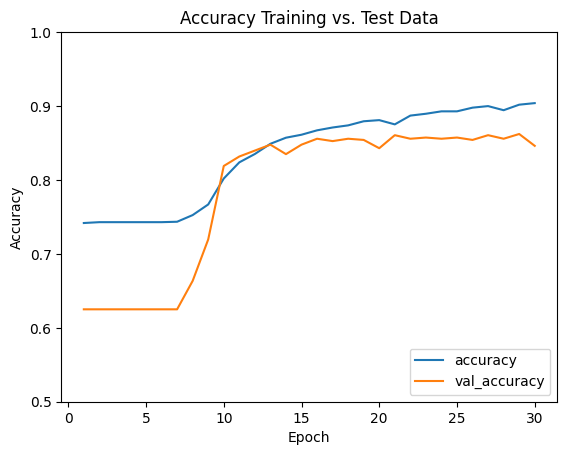

In [117]:
plt.plot(np.arange(30)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(30)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

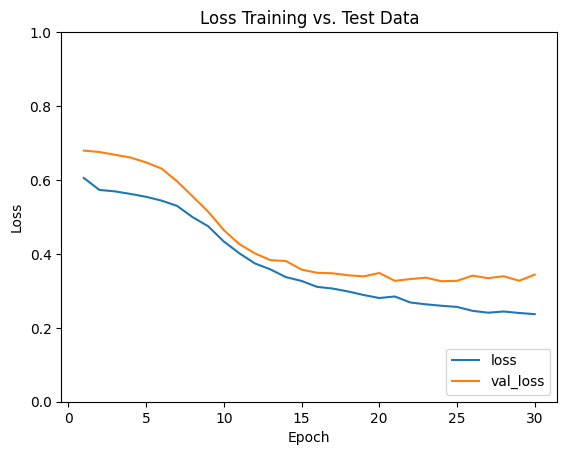

In [118]:
plt.plot(np.arange(30)+1,history.history['loss'], label='loss')
plt.plot(np.arange(30)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

In [119]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(256,(3,5), activation='relu', input_shape=(100, 250, 1)))

model.add(layers.MaxPooling2D(3,5))
model.add(layers.Dropout(0.15))
model.add(layers.Conv2D(64,(2,5), activation='relu'))

model.add(layers.MaxPooling2D(2,5))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128,(2,3), activation='relu'))

model.add(layers.MaxPooling2D(2,3))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 98, 246, 256)   │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 20, 49, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 49, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 19, 45, 64)     │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 4, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 3, 7, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,434 (978.26 KB)

 Trainable params: 250,434 (978.26 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=30, 
                    validation_data=(test_images, test_labels))

Epoch 1/30
 52/163 ━━━━━━━━━━━━━━━━━━━━ 1:05 593ms/step - accuracy: 0.6709 - loss: 0.6478

163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 618ms/step - accuracy: 0.7137 - loss: 0.6132 - val_accuracy: 0.6250 - val_loss: 0.6794
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.7521 - loss: 0.5591 - val_accuracy: 0.6250 - val_loss: 0.6550
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.7524 - loss: 0.5338 - val_accuracy: 0.6266 - val_loss: 0.5857
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.7812 - loss: 0.4632 - val_accuracy: 0.7965 - val_loss: 0.4695
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.8274 - loss: 0.3863 - val_accuracy: 0.8285 - val_loss: 0.4147
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.8683 - loss: 0.3167 - val_accuracy: 0.8397 - val_loss: 0.3855
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.8858 - loss: 0.2766 - val_accuracy: 0.8510 - val_loss: 0.3602
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.8989 - loss: 0.24

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

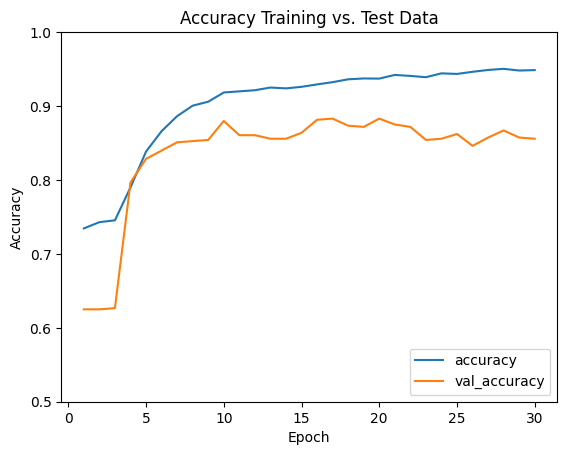

In [121]:
plt.plot(np.arange(30)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(30)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

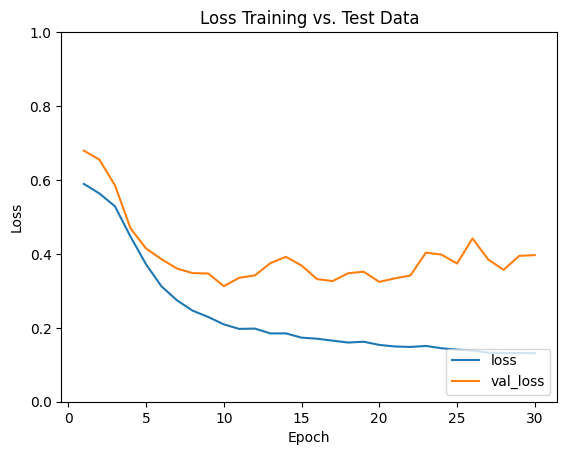

In [122]:
plt.plot(np.arange(30)+1,history.history['loss'], label='loss')
plt.plot(np.arange(30)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

This has a particularly good accuracy of 88%, although the does not occur with the minimum loss.  The minimum loss is approximately 0.31.

In [123]:
model = None
modelCNN = models.Sequential()
modelCNN.add(layers.Conv2D(512,(3,5), activation='relu', input_shape=(100, 250, 1)))

modelCNN.add(layers.MaxPooling2D(3,5))
modelCNN.add(layers.Dropout(0.15))
modelCNN.add(layers.Conv2D(128,(2,5), activation='relu'))

modelCNN.add(layers.MaxPooling2D(2,5))
modelCNN.add(layers.Dropout(0.25))
modelCNN.add(layers.Conv2D(258,(2,3), activation='relu'))

modelCNN.add(layers.MaxPooling2D(2,3))
modelCNN.add(layers.Dropout(0.4))
modelCNN.add(layers.Flatten())
modelCNN.add(layers.Dense(512, activation='relu'))
modelCNN.add(layers.Dense(2))

modelCNN.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 98, 246, 512)   │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 20, 49, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 49, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 19, 45, 128)    │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 4, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 3, 7, 258)      │       198,402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 1, 2, 258)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 2, 258)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 516)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 512)            │       264,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,127,812 (4.30 MB)

 Trainable params: 1,127,812 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
modelCNN.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

historyCNN = modelCNN.fit(train_images, train_labels, epochs=30,
                    validation_data=(test_images, test_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=2, start_from_epoch=10, restore_best_weights=True, verbose=1)])

Epoch 1/30


163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.7207 - loss: 0.5986 - val_accuracy: 0.6250 - val_loss: 0.6670
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7521 - loss: 0.5453 - val_accuracy: 0.8109 - val_loss: 0.5534
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8010 - loss: 0.4357 - val_accuracy: 0.8397 - val_loss: 0.3858
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8663 - loss: 0.3106 - val_accuracy: 0.8638 - val_loss: 0.3273
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.8971 - loss: 0.2431 - val_accuracy: 0.8590 - val_loss: 0.3092
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9165 - loss: 0.2099 - val_accuracy: 0.8782 - val_loss: 0.3004
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9210 - loss: 0.1890 - val_accuracy: 0.8686 - val_loss: 0.2997
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9307 - loss: 0.1702 - val_accuracy: 0.876

For this last model, there seem to be times where the accuracy on the testing data is higher than on the training data.  I would usually account this to luck, but it happens regularly early on.  Perhaps the underfitting on the training data early on is in fact a good thing overall.  The accuracy is up to 88.62% on the test data, a slight improvement over the previous model.  The minimum loss is lower at 0.2997, although where this model was stopped it is 0.3161, again a minor improvement.

In [126]:
predTrainArray = modelCNN.predict(train_images)
predArray = modelCNN.predict(test_images)

TrainPred = np.zeros(5216)
for i in range(5216):
    if predTrainArray[i][0]<predTrainArray[i][1]:
        TrainPred[i]=1
    i+=1

TestPred = np.zeros(624)
for i in range(624):
    if predArray[i][0]<predArray[i][1]:
        TestPred[i]=1
    i+=1

TrainCompare = (TrainPred == yTrain)
TestCompare = (TestPred == yTest)
print("Training Accuracy: {:.2f}%".format(100*(TrainCompare.sum()/5216)))
print("Test Accuracy: {:.2f}%".format(100*(TestCompare.sum()/624)))
print("Training Specificity: {:.2f}%".format(100*(TrainCompare[:1341].sum()/1341)))
print("Test Specificity: {:.2f}%".format(100*(TestCompare[:234].sum()/234)))
print("Training Sensitivity: {:.2f}%".format(100*(TrainCompare[1341:].sum()/3875)))
print("Test Sensitivity: {:.2f}%".format(100*(TestCompare[234:].sum()/390)))

163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 276ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step
Training Accuracy: 93.48%
Test Accuracy: 88.62%
Training Specificity: 97.69%
Test Specificity: 80.34%
Training Sensitivity: 92.03%
Test Sensitivity: 93.59%


Here we can see the accuracy, specificity, and sensitivity on the test and training data sets.  From before, our specificity was always poor on the training data meaning that the models would over-diagnose pneumonia.  Here it is slightly over 80%, which is a good improvment.


| | Training Accuracy | Training Sensitivity | Training Specificity | Test Accuracy | Test Sensitivity | Test Specificity |
|---| --- | ---| ---| --- | --- | --- |
| (Project 1) Ensemble of 3 Models | 90.82 % | 89.03% | 95.97% | 82.37 % | 88.72 % | 71.79 % |
| (Project 2) 75% Explained Variance PCA/KNN | 97.18 % | 98.25% | 94.11 % | 79.17% | 97.87 % | 52.99 % |
| (Project 2) 75% Explained Variance PCA/Heirarchical Cluster | 83.03 % | 83.72 % | 78.60 % | 75.96 % | 84.10 % | 62.39% |
| (Project 3) CNN | 93.48 % | 92.03 % | 97.69 % | 88.62 % | 93.59 % | 80.34 % |


---

### PCA Revisited (Project 2)
We will reload the PCA data for 50%, 75%, 90%, 95%, and 99% explained variance.  From here we will get the coefficients of each picture's projection onto the eigenvectors.  We will need to consider how to scale these coefficients.  There is no particular restriction on what the coefficients may be, positive or negative.  I would assume, and observed, that the largest coefficients tend to come first as those ones look "the most like" x-ray images.  I will need to take an absolute value of the coefficeints and then consider further scaling or using a proper activation function.

The image and training images were altered to run before, so we must reload them.

In [130]:
yTrain = np.zeros(1341)
yTrain = np.append(yTrain,np.ones(3875))
imgTrain = np.empty((5216,25000))
with open('traindata.csv', 'r') as file:
    readFile = csv.reader(file)
    idx = 0
    for line in readFile:
        # imgTrain = np.append(imgTrain,[np.array(line, dtype=float)],axis=0)
        imgTrain[idx] = np.array(line, dtype=float)
        idx += 1

yTest = np.zeros(234)
yTest = np.append(yTest,np.ones(390))
imgTest = np.empty([624,25000])
idx = 0
with open('testdata.csv', 'r') as file:
    readFile = csv.reader(file)
    for line in readFile:
        imgTest[idx] = np.array(line, dtype=float)
        idx+=1


In [131]:
# From Project 2

from sklearn.preprocessing import StandardScaler
    
class PCA:
    def __init__(self, target_explained_variance=None):
        """
        
        """
        self.target_explained_variance = target_explained_variance
        self.feature_size = -1
        self.eVals = np.array([])
        self.eVecs = np.array([])
        self.w_matrix = np.array([])
        self.X_std = np.array([])
        self.cov_mat = np.array([])

    def standardize(self, X):
        """
        """
        
        return StandardScaler().fit_transform(X)
         

    def compute_mean_vector(self, X_std):
        """
        """
        resVec = np.zeros(X_std.shape[1])
        idx = 0
        for i in np.transpose(X_std):
            resVec[idx] = np.average(i)
            idx+=1

        return resVec
         

    def compute_cov(self, X_std):
        """

        """

        res = np.matmul(np.transpose(X_std),X_std)        
        
        return res

                                            
         

    def compute_eigen_vector(self, cov_mat):
        """
        41 minutes, values saved to csv file
        """

        # https://github.com/scipy/scipy/issues/9212 

        # This will compute the eigenvalues and eigenvectors

        #res = scipy.linalg.eigh(cov_mat, turbo= True, check_finite= False, b = np.eye(cov_mat.shape[0], dtype = float))
        # eVals = np.real(res[0])
        # eVecs = np.real(res[1])

        # This will read the eigenvalues and eigenvectors from the saved file.
        eVals = np.zeros([25000])
        with open('eigenvalues.csv', 'r') as file:
            readFile = csv.reader(file)
            for line in readFile:
                eVals = np.array(line, dtype=float)

        idx = 0
        eVecs = np.zeros([25000,25000])
        with open('eigenvectors.csv', 'r') as file:
            readFile = csv.reader(file)
            for line in readFile:
                eVecs[idx] = np.array(line, dtype=float)
                idx+=1
 

        return (eVals,eVecs)
         

    def compute_explained_variance(self, eigen_vals):
        """
    
        """
        eigen_vals
        return eigen_vals/eigen_vals.sum()
         

    def cumulative_sum(self, var_exp):
        """

        """
        return np.cumsum(var_exp)

    def compute_weight_matrix2(self, cum_var_exp):
        
        """
        """
        
        matrix_w = np.ones((self.feature_size, 1))

        currVar = 0
        idx = 0
        while currVar < self.target_explained_variance:
            
            matrix_w = np.append(matrix_w,np.transpose([self.eVecs[idx]]),axis=1)
            currVar = cum_var_exp[idx]
            idx +=1

            
        
        return matrix_w
         
    def compute_weight_matrix(self, cum_var_exp):
        
        """
        """
    

        currVar = 0
        idx = 0
        while currVar < self.target_explained_variance:
            currVar = cum_var_exp[idx]
            idx +=1

        matrix_w = np.transpose(self.eVecs[:idx])

            
        
        return matrix_w
         

    def transform_data(self, X_std, matrix_w):
        """
        """
        return X_std.dot(matrix_w)

    def fit(self, X):
        """    
        """
    
        self.feature_size = X.shape[1]
        print('Size = '+str(self.feature_size))
        
        if len(self.X_std)==0:
            X_std = self.standardize(X)
            self.X_std = X_std

        if len(self.cov_mat)==0:
            cov_mat = self.compute_cov(X_std)
            self.cov_mat = cov_mat

        if len(self.eVals)==0:
            eig_vals, eig_vecs = self.compute_eigen_vector(cov_mat)  

            self.eVals = eig_vals
            self.eVecs = eig_vecs


        var_exp = self.compute_explained_variance(self.eVals)
        cum_var_exp = self.cumulative_sum(var_exp)


        matrix_w = self.compute_weight_matrix(cum_var_exp=cum_var_exp) 

        self.w_matrix = matrix_w
    
        print(len(matrix_w),len(matrix_w[0]))
        return self.transform_data(X_std=self.X_std, matrix_w=matrix_w)

In [132]:
pca_handler50 = PCA(target_explained_variance=0.5)

imgTrain_updated50 = pca_handler50.fit(imgTrain)

pca_handler75 = PCA(target_explained_variance=0.75)
pca_handler75.eVals = pca_handler50.eVals
pca_handler75.eVecs = pca_handler50.eVecs
pca_handler75.X_std = pca_handler50.X_std
pca_handler75.cov_mat = pca_handler50.cov_mat
imgTrain_updated75 = pca_handler75.fit(imgTrain)

pca_handler90 = PCA(target_explained_variance=0.9)
pca_handler90.eVals = pca_handler50.eVals
pca_handler90.eVecs = pca_handler50.eVecs
pca_handler90.X_std = pca_handler50.X_std
pca_handler90.cov_mat = pca_handler50.cov_mat
imgTrain_updated90 = pca_handler90.fit(imgTrain)

pca_handler95 = PCA(target_explained_variance=0.95)
pca_handler95.eVals = pca_handler50.eVals
pca_handler95.eVecs = pca_handler50.eVecs
pca_handler95.X_std = pca_handler50.X_std
pca_handler95.cov_mat = pca_handler50.cov_mat
imgTrain_updated95 = pca_handler95.fit(imgTrain)

pca_handler99 = PCA(target_explained_variance=0.99)
pca_handler99.eVals = pca_handler50.eVals
pca_handler99.eVecs = pca_handler50.eVecs
pca_handler99.X_std = pca_handler50.X_std
pca_handler99.cov_mat = pca_handler50.cov_mat
imgTrain_updated99 = pca_handler99.fit(imgTrain)



Size = 25000


25000 4
Size = 25000
25000 22
Size = 25000
25000 151
Size = 25000
25000 423
Size = 25000
25000 1837


In [161]:
imgTest_updated50 = pca_handler50.standardize(imgTest).dot(pca_handler50.w_matrix)
imgTest_updated75 = pca_handler50.standardize(imgTest).dot(pca_handler75.w_matrix)
imgTest_updated90 = pca_handler50.standardize(imgTest).dot(pca_handler90.w_matrix)
imgTest_updated95 = pca_handler50.standardize(imgTest).dot(pca_handler95.w_matrix)
imgTest_updated99 = pca_handler50.standardize(imgTest).dot(pca_handler99.w_matrix)

---

## 50% explained

After adjusting the learning rate and dropout rate, there are still many epochs required, but is fast.  The increases occur in leaps

In [258]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(4, 1))
model.add(layers.SimpleRNN(4, activation="relu", dropout=0.25, unroll=True))

model.add(layers.Dense(2))

model.build((4,1))
model.summary()


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (4, 1, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_51 (SimpleRNN)       │ (4, 4)                 │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (4, 2)                 │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (152.00 B)

 Trainable params: 38 (152.00 B)

 Non-trainable params: 0 (0.00 B)

In [259]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated50, train_labels, epochs=150, 
                    validation_data=(imgTest_updated50, test_labels))

Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5904 - loss: 0.6935 - val_accuracy: 0.6218 - val_loss: 0.6889
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7470 - loss: 0.6806 - val_accuracy: 0.6250 - val_loss: 0.6831
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.7518 - loss: 0.6682 - val_accuracy: 0.6250 - val_loss: 0.6780
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7521 - loss: 0.6557 - val_accuracy: 0.6250 - val_loss: 0.6730
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.7521 - loss: 0.6426 - val_accuracy: 0.6250 - val_loss: 0.6684
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7521 - loss: 0.6288 - val_accuracy: 0.6250 - val_loss: 0.6648
Epoch 7/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.7521 - loss: 0.6136 - val_accuracy: 0.6250 - val_loss: 0.6628
Epoch 8/150
135/163 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.7538 - loss: 0.5

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.7521 - loss: 0.5998 - val_accuracy: 0.6250 - val_loss: 0.6637
Epoch 9/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7521 - loss: 0.5850 - val_accuracy: 0.6250 - val_loss: 0.6678
Epoch 10/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.7521 - loss: 0.5733 - val_accuracy: 0.6250 - val_loss: 0.6741
Epoch 11/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7521 - loss: 0.5674 - val_accuracy: 0.6250 - val_loss: 0.6805
Epoch 12/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.7521 - loss: 0.5645 - val_accuracy: 0.6250 - val_loss: 0.6855
Epoch 13/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.7521 - loss: 0.5629 - val_accuracy: 0.6250 - val_loss: 0.6892
Epoch 14/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.7521 - loss: 0.5623 - val_accuracy: 0.6250 - val_loss: 0.6911
Epoch 15/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7521 - loss: 0.5625 

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

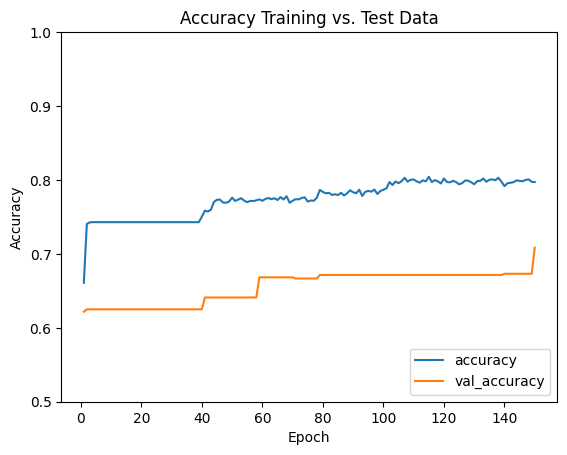

In [260]:
plt.plot(np.arange(150)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(150)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

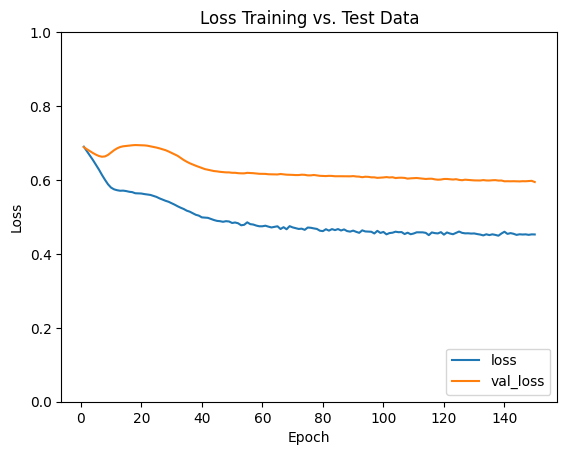

In [261]:
plt.plot(np.arange(150)+1,history.history['loss'], label='loss')
plt.plot(np.arange(150)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

So I will try to create stacks of RNNs.

In [262]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(4, 1))
model.add(layers.SimpleRNN(4, activation="relu", dropout=0.25, unroll=True, return_sequences=True))
model.add(layers.SimpleRNN(4, activation="relu", dropout=0.25, unroll=True))

model.add(layers.Dense(2))

model.build((4,1))
model.summary()

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ (4, 1, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_52 (SimpleRNN)       │ (4, 1, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_53 (SimpleRNN)       │ (4, 4)                 │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (4, 2)                 │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (296.00 B)

 Trainable params: 74 (296.00 B)

 Non-trainable params: 0 (0.00 B)

In [263]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated50, train_labels, epochs=150, 
                    validation_data=(imgTest_updated50, test_labels))

Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7464 - loss: 0.6636 - val_accuracy: 0.6250 - val_loss: 0.6444
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7549 - loss: 0.6095 - val_accuracy: 0.6250 - val_loss: 0.6240
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.7521 - loss: 0.5736 - val_accuracy: 0.6250 - val_loss: 0.6226
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.7521 - loss: 0.5587 - val_accuracy: 0.6250 - val_loss: 0.6259
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.7521 - loss: 0.5487 - val_accuracy: 0.6250 - val_loss: 0.6277
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.7521 - loss: 0.5433 - val_accuracy: 0.6250 - val_loss: 0.6273
Epoch 7/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.7521 - loss: 0.5417 - val_accuracy: 0.6250 - val_loss: 0.6246
Epoch 8/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.7524 - loss: 0.5

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

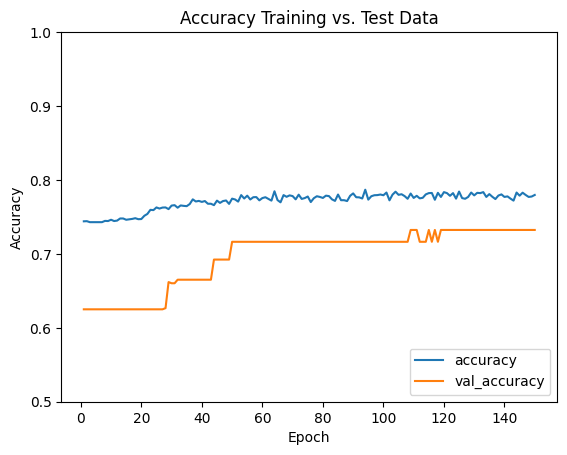

In [264]:
plt.plot(np.arange(150)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(150)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

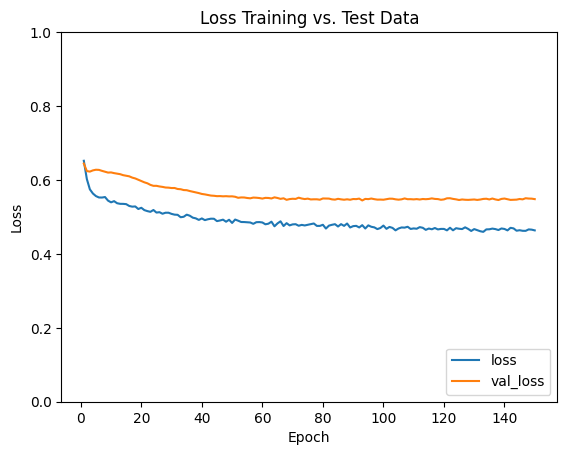

In [265]:
plt.plot(np.arange(150)+1,history.history['loss'], label='loss')
plt.plot(np.arange(150)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

We can see that the loss goes down very slowly, and again the accuracy increases in leaps, not necessarily consistently and reliabily.

---

## 75% Explained variance

In [266]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(22, 1))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.1, unroll=True))

model.add(layers.Dense(2))

model.build((22,1))
model.summary()



Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ (22, 1, 1)             │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_54 (SimpleRNN)       │ (22, 22)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (22, 2)                │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596 (2.33 KB)

 Trainable params: 596 (2.33 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated75, train_labels, epochs=150, 
                    validation_data=(imgTest_updated75, test_labels))

Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5004 - loss: 0.6941 - val_accuracy: 0.6250 - val_loss: 0.6870
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7521 - loss: 0.6750 - val_accuracy: 0.6250 - val_loss: 0.6725
Epoch 3/150
  1/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6875 - loss: 0.6593

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.7521 - loss: 0.6123 - val_accuracy: 0.6250 - val_loss: 0.6962
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7521 - loss: 0.5604 - val_accuracy: 0.6250 - val_loss: 0.6947
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.7521 - loss: 0.5604 - val_accuracy: 0.6250 - val_loss: 0.6940
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7521 - loss: 0.5604 - val_accuracy: 0.6250 - val_loss: 0.6936
Epoch 7/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.7521 - loss: 0.5603 - val_accuracy: 0.6250 - val_loss: 0.6933
Epoch 8/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.7521 - loss: 0.5602 - val_accuracy: 0.6250 - val_loss: 0.6927
Epoch 9/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7521 - loss: 0.5598 - val_accuracy: 0.6250 - val_loss: 0.6923
Epoch 10/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.7521 - loss: 0.5593 - val

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

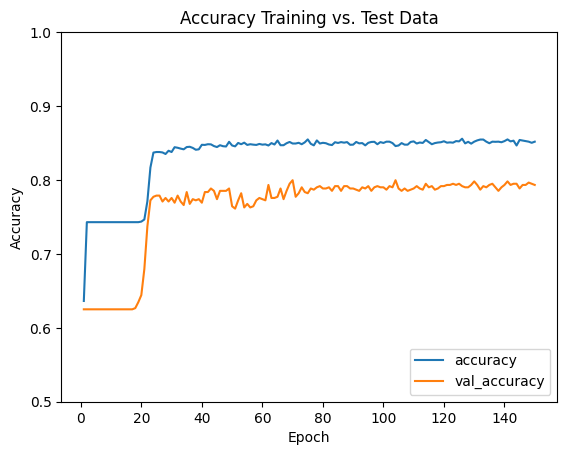

In [268]:
plt.plot(np.arange(150)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(150)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

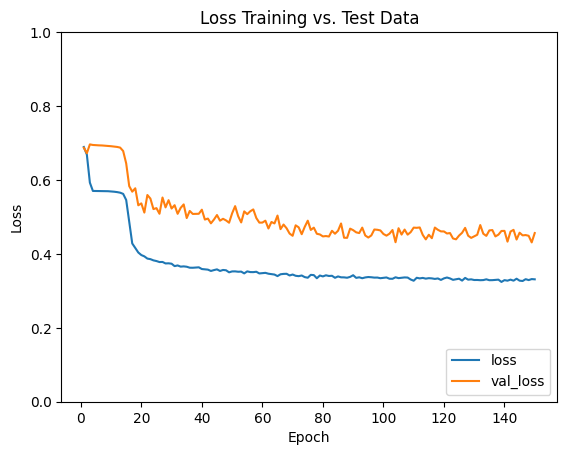

In [269]:
plt.plot(np.arange(150)+1,history.history['loss'], label='loss')
plt.plot(np.arange(150)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

We can see even fitting the training data is difficult, but here we get over 85% accuracy on the training data and 80% on the test data.  There is more noise here and the increases are less monotonic.  This one may be tuned to get a better result.

---

### 90% Explained Variance

In [282]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(151, 1))
model.add(layers.SimpleRNN(151, activation="relu", dropout=0.15, unroll=True))

model.add(layers.Dense(2))

model.build((151,1))
model.summary()

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (151, 1, 1)            │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_62 (SimpleRNN)       │ (151, 151)             │        23,103 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (151, 2)               │           304 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,558 (92.02 KB)

 Trainable params: 23,558 (92.02 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated90, train_labels, epochs=100, 
                    validation_data=(imgTest_updated90, test_labels))

Epoch 1/100


163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7253 - loss: 0.6664 - val_accuracy: 0.6250 - val_loss: 0.6789
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5591 - val_accuracy: 0.6250 - val_loss: 0.6782
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5565 - val_accuracy: 0.6250 - val_loss: 0.6783
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5525 - val_accuracy: 0.6250 - val_loss: 0.6683
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5415 - val_accuracy: 0.6250 - val_loss: 0.6348
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5213 - val_accuracy: 0.6250 - val_loss: 0.6075
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5049 - val_accuracy: 0.6250 - val_loss: 0.6037
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7521 - loss: 0.5021 - val_accuracy: 0.625

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

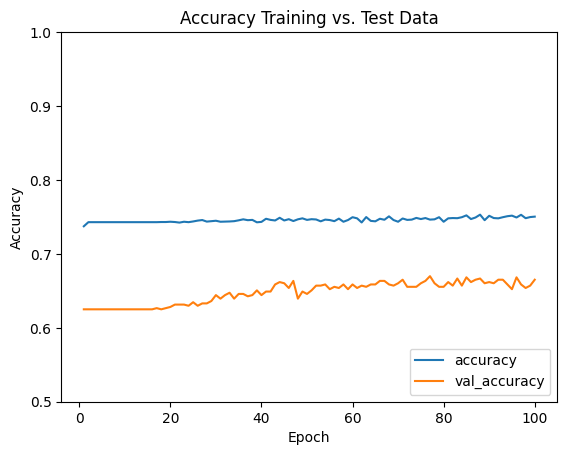

In [284]:
plt.plot(np.arange(100)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(100)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

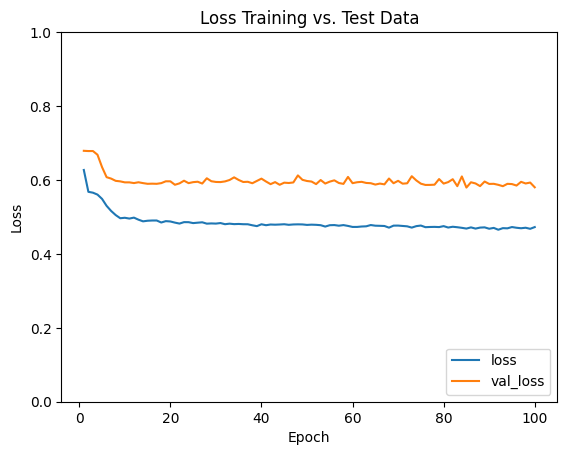

In [285]:
plt.plot(np.arange(100)+1,history.history['loss'], label='loss')
plt.plot(np.arange(100)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

---

## 95% Explained Varaince

In [286]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(423, 1))
model.add(layers.SimpleRNN(423, activation="relu", dropout=0.15, unroll=True))

model.add(layers.Dense(2))

model.build((423,1))
model.summary()

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_51 (Embedding)        │ (423, 1, 1)            │           423 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_63 (SimpleRNN)       │ (423, 423)             │       179,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (423, 2)               │           848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,046 (707.21 KB)

 Trainable params: 181,046 (707.21 KB)

 Non-trainable params: 0 (0.00 B)

In [287]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated95, train_labels, epochs=50, 
                    validation_data=(imgTest_updated95, test_labels))

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.7499 - loss: 0.6446 - val_accuracy: 0.6250 - val_loss: 0.6760
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.7521 - loss: 0.5625 - val_accuracy: 0.6250 - val_loss: 0.6787
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7521 - loss: 0.5597 - val_accuracy: 0.6250 - val_loss: 0.6793
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7521 - loss: 0.5612 - val_accuracy: 0.6250 - val_loss: 0.6807
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7521 - loss: 0.5590 - val_accuracy: 0.6250 - val_loss: 0.6784
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7521 - loss: 0.5575 - val_accuracy: 0.6250 - val_loss: 0.6756
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7521 - loss: 0.5555 - val_accuracy: 0.6250 - val_loss: 0.6715
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.7521 - loss: 0

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

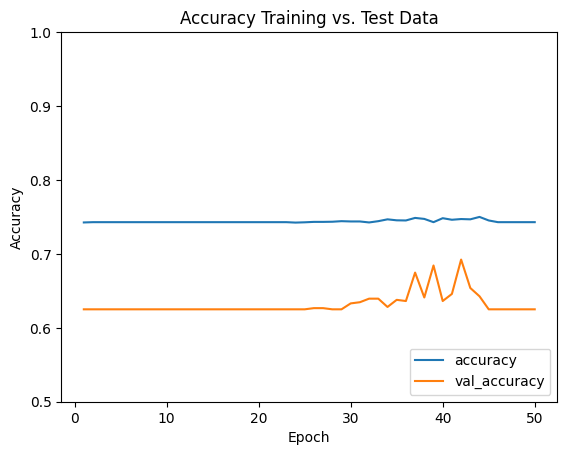

In [288]:
plt.plot(np.arange(50)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(50)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

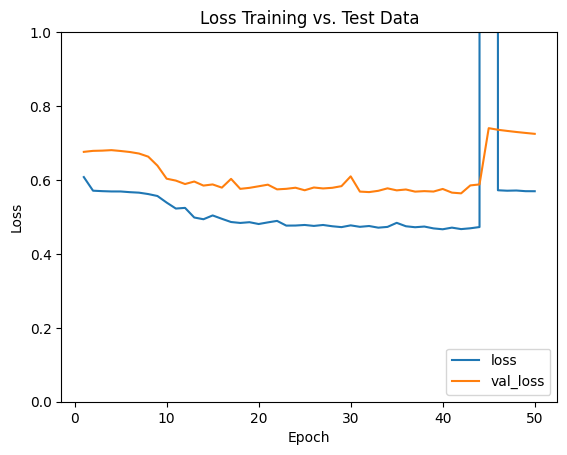

In [290]:
plt.plot(np.arange(50)+1,history.history['loss'], label='loss')
plt.plot(np.arange(50)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

We can see that this is not great.  As the explained variance increases, it seems that even fitting the training data is more difficult.  I will forgo the 99% explained variance.

---

### Tuning the 75% 

The 75% explained varaince consistently performs better than the others.  My guess is that this is because the higher eigenvectors are irrelevent and causing additional noise.  I am operating under the assumption the earliest eigenvectors are the most relevent, in particular between number 5 and 22.  So I will try altering these sequences to repeat ones that might be more important.

In [299]:
# Repeats all 5 times in teh training set.  No need for the values.
xpmnt1 = np.repeat(imgTrain_updated75,5,axis=1)
ypmnt1 = np.repeat(imgTest_updated75,5,axis=1)

In [303]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(110, 1))
model.add(layers.SimpleRNN(110, activation="relu", dropout=0.2, unroll=True))

model.add(layers.Dense(2))

model.build((110,1))
model.summary()



Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_54 (Embedding)        │ (110, 1, 1)            │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_66 (SimpleRNN)       │ (110, 110)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (110, 2)               │           222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,652 (49.42 KB)

 Trainable params: 12,652 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [304]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xpmnt1, train_labels, epochs=200, 
                    validation_data=(ypmnt1, test_labels))

Epoch 1/200


163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7234 - loss: 0.6788 - val_accuracy: 0.6250 - val_loss: 0.6823
Epoch 2/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5628 - val_accuracy: 0.6250 - val_loss: 0.6927
Epoch 3/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5614 - val_accuracy: 0.6250 - val_loss: 0.6939
Epoch 4/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5612 - val_accuracy: 0.6250 - val_loss: 0.6953
Epoch 5/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5610 - val_accuracy: 0.6250 - val_loss: 0.6954
Epoch 6/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5610 - val_accuracy: 0.6250 - val_loss: 0.6950
Epoch 7/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5610 - val_accuracy: 0.6250 - val_loss: 0.6958
Epoch 8/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5608 - val_accuracy: 0.6250

This is a rather distubring development that I do not get a good improvement here, in fact this is as bad as just predicting everything to be pnuemonia.  This makes me re-evaluate why the previous models failed, maybe with long sequences, I should do something different.  I will try looking at only components 5-22. 

In [321]:
ypmnt2 = imgTest_updated75[:,4:]
xpmnt2 = imgTrain_updated75[:,4:]

In [316]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(18, 1))
model.add(layers.SimpleRNN(18, activation="relu", dropout=0.1, unroll=True))

model.add(layers.Dense(2))

model.build((18,1))
model.summary()

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_55 (Embedding)        │ (18, 1, 1)             │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_67 (SimpleRNN)       │ (18, 18)               │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (18, 2)                │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416 (1.62 KB)

 Trainable params: 416 (1.62 KB)

 Non-trainable params: 0 (0.00 B)

In [322]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xpmnt2, train_labels, epochs=200, 
                    validation_data=(ypmnt2, test_labels))

Epoch 1/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7451 - loss: 0.6858 - val_accuracy: 0.6250 - val_loss: 0.6841
Epoch 2/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7521 - loss: 0.6647 - val_accuracy: 0.6250 - val_loss: 0.6559
Epoch 3/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.7521 - loss: 0.5718 - val_accuracy: 0.6250 - val_loss: 0.6862
Epoch 4/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7521 - loss: 0.5564 - val_accuracy: 0.6250 - val_loss: 0.6843
Epoch 5/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.7521 - loss: 0.5565 - val_accuracy: 0.6250 - val_loss: 0.6832
Epoch 6/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7521 - loss: 0.5553 - val_accuracy: 0.6250 - val_loss: 0.6817
Epoch 7/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7521 - loss: 0.5532 - val_accuracy: 0.6250 - val_loss: 0.6791
Epoch 8/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7521 - loss: 0.5

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7521 - loss: 0.5505 - val_accuracy: 0.6250 - val_loss: 0.6748
Epoch 10/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7521 - loss: 0.5478 - val_accuracy: 0.6250 - val_loss: 0.6719
Epoch 11/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7521 - loss: 0.5449 - val_accuracy: 0.6250 - val_loss: 0.6708
Epoch 12/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.7521 - loss: 0.5442 - val_accuracy: 0.6250 - val_loss: 0.6689
Epoch 13/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7521 - loss: 0.5398 - val_accuracy: 0.6250 - val_loss: 0.6677
Epoch 14/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7521 - loss: 0.5399 - val_accuracy: 0.6250 - val_loss: 0.6647
Epoch 15/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7521 - loss: 0.5373 - val_accuracy: 0.6250 - val_loss: 0.6638
Epoch 16/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7521 - loss: 0.5345

Here we have a decent accuracy fo the training data, but not the test data.  This tells me maybe the first 5 are more important than I thought.

In [335]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(22, 1))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.2, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.1, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", unroll=True))

model.add(layers.Dense(2))

model.build((22,1))
model.summary()

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_63 (Embedding)        │ (22, 1, 1)             │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_85 (SimpleRNN)       │ (22, 1, 22)            │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_86 (SimpleRNN)       │ (22, 1, 22)            │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_87 (SimpleRNN)       │ (22, 22)               │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (22, 2)                │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,588 (14.02 KB)

 Trainable params: 3,588 (14.02 KB)

 Non-trainable params: 0 (0.00 B)

In [336]:
model.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated75, train_labels, epochs=300, 
                    validation_data=(imgTest_updated75, test_labels))

Epoch 1/300
 87/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4355 - loss: 0.6952

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4980 - loss: 0.6942 - val_accuracy: 0.6250 - val_loss: 0.6913
Epoch 2/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7457 - loss: 0.6891 - val_accuracy: 0.6250 - val_loss: 0.6895
Epoch 3/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6849 - val_accuracy: 0.6250 - val_loss: 0.6860
Epoch 4/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6771 - val_accuracy: 0.6250 - val_loss: 0.6809
Epoch 5/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6644 - val_accuracy: 0.6250 - val_loss: 0.6740
Epoch 6/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6458 - val_accuracy: 0.6250 - val_loss: 0.6659
Epoch 7/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6196 - val_accuracy: 0.6250 - val_loss: 0.6607
Epoch 8/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.5905 - val_accuracy: 0.6250

Text(0.5, 1.0, 'Accuracy Training vs. Test Data')

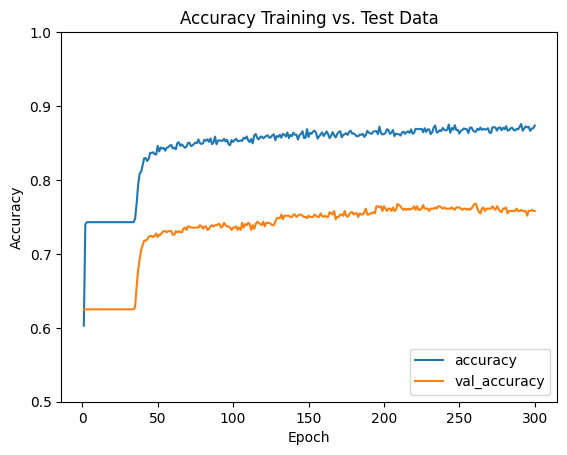

In [338]:
plt.plot(np.arange(300)+1,history.history['accuracy'], label='accuracy')
plt.plot(np.arange(300)+1,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy Training vs. Test Data")

Text(0.5, 1.0, 'Loss Training vs. Test Data')

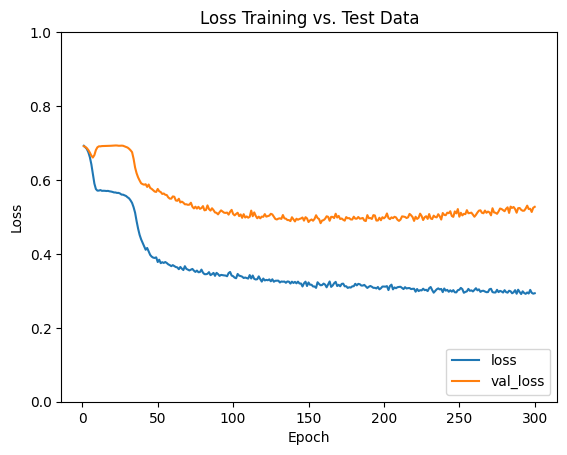

In [340]:
plt.plot(np.arange(300)+1,history.history['loss'], label='loss')
plt.plot(np.arange(300)+1,history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Loss Training vs. Test Data")

With this setup, we have a training accuracy of about 85% and a test accuracy of 75% at best.  Pehaps running mulple RNN's with different dropout rates would give a better result.

In [341]:
model = None
model = keras.Sequential()


model.add(keras.layers.Embedding(22, 1))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.4, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.3, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.2, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", dropout=0.1, unroll=True,return_sequences=True))
model.add(layers.Dense(22))
model.add(layers.SimpleRNN(22, activation="relu", unroll=True))

model.add(layers.Dense(2))

model.build((22,1))
model.summary()

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_64 (Embedding)        │ (22, 1, 1)             │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_88 (SimpleRNN)       │ (22, 1, 22)            │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_89 (SimpleRNN)       │ (22, 1, 22)            │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_90 (SimpleRNN)       │ (22, 1, 22)            │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_91 (SimpleRNN)       │ (22, 1, 22)            │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (22, 1, 22)            │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_92 (SimpleRNN)       │ (22, 22)               │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (22, 2)                │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,580 (25.70 KB)

 Trainable params: 6,580 (25.70 KB)

 Non-trainable params: 0 (0.00 B)

In [342]:
model.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(imgTrain_updated75, train_labels, epochs=300, 
                    validation_data=(imgTest_updated75, test_labels))

Epoch 1/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7477 - loss: 0.6820 - val_accuracy: 0.6250 - val_loss: 0.6790
Epoch 2/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.6522 - val_accuracy: 0.6250 - val_loss: 0.6610
Epoch 3/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.6032 - val_accuracy: 0.6250 - val_loss: 0.6646
Epoch 4/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5813 - val_accuracy: 0.6250 - val_loss: 0.6748
Epoch 5/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5725 - val_accuracy: 0.6250 - val_loss: 0.6775
Epoch 6/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5763 - val_accuracy: 0.6250 - val_loss: 0.6777
Epoch 7/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5721 - val_accuracy: 0.6250 - val_loss: 0.6786
Epoch 8/300
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5690 - val_accu

Interestingly, this one has about the same training accuracy, but the test accuracy is about 80%.  I think I will try this one to get an operating model, but this will require patience to be set very high and a very late start.  

In [357]:
modelRNN = keras.Sequential()


modelRNN.add(keras.layers.Embedding(22, 1))
modelRNN.add(layers.SimpleRNN(22, activation="relu", dropout=0.4, unroll=True,return_sequences=True))
modelRNN.add(layers.Dense(22))
modelRNN.add(layers.SimpleRNN(22, activation="relu", dropout=0.3, unroll=True,return_sequences=True))
modelRNN.add(layers.Dense(22))
modelRNN.add(layers.SimpleRNN(22, activation="relu", dropout=0.2, unroll=True,return_sequences=True))
modelRNN.add(layers.Dense(22))
modelRNN.add(layers.SimpleRNN(22, activation="relu", dropout=0.1, unroll=True,return_sequences=True))
modelRNN.add(layers.Dense(22))
modelRNN.add(layers.SimpleRNN(22, activation="relu", unroll=True))

modelRNN.add(layers.Dense(2))

modelRNN.build((22,1))
modelRNN.compile(optimizer=keras.optimizers.Adam(0.00002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelRNN.fit(imgTrain_updated75, train_labels, epochs=1000, 
                    validation_data=(imgTest_updated75, test_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=50, start_from_epoch=150, restore_best_weights=True, verbose=1)])

Epoch 1/1000


163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6037 - loss: 0.6914 - val_accuracy: 0.6250 - val_loss: 0.6848
Epoch 2/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7509 - loss: 0.6643 - val_accuracy: 0.6250 - val_loss: 0.6613
Epoch 3/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - loss: 0.5849 - val_accuracy: 0.6250 - val_loss: 0.6899
Epoch 4/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5719 - val_accuracy: 0.6250 - val_loss: 0.6894
Epoch 5/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5662 - val_accuracy: 0.6250 - val_loss: 0.6896
Epoch 6/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5713 - val_accuracy: 0.6250 - val_loss: 0.6880
Epoch 7/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5685 - val_accuracy: 0.6250 - val_loss: 0.6904
Epoch 8/1000
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.5701 - val_accuracy:

In [358]:
predTrainArray = modelRNN.predict(imgTrain_updated75)
predArray = modelRNN.predict(imgTest_updated75)

TrainPred = np.zeros(5216)
for i in range(5216):
    if predTrainArray[i][0]<predTrainArray[i][1]:
        TrainPred[i]=1
    i+=1

TestPred = np.zeros(624)
for i in range(624):
    if predArray[i][0]<predArray[i][1]:
        TestPred[i]=1
    i+=1

TrainCompare = (TrainPred == train_labels)
TestCompare = (TestPred == test_labels)
print("Training Accuracy: {:.2f}%".format(100*(TrainCompare.sum()/5216)))
print("Test Accuracy: {:.2f}%".format(100*(TestCompare.sum()/624)))
print("Training Specificity: {:.2f}%".format(100*(TrainCompare[:1341].sum()/1341)))
print("Test Specificity: {:.2f}%".format(100*(TestCompare[:234].sum()/234)))
print("Training Sensitivity: {:.2f}%".format(100*(TrainCompare[1341:].sum()/3875)))
print("Test Sensitivity: {:.2f}%".format(100*(TestCompare[234:].sum()/390)))

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training Accuracy: 86.79%
Test Accuracy: 76.44%
Training Specificity: 78.15%
Test Specificity: 52.99%
Training Sensitivity: 89.78%
Test Sensitivity: 90.51%


---

## Conclusion
CNN was a success for image analysis, for the reason that is the intent.  It is even the best model.  RNN on the otherhand seems unreliable for this purpose.  There is perhaps some other things I could do to figure out a better implementation.  Oddly enough, the best overall model on the Training data was KNN with 75% explained variance.  CNN had the best specificity, which was the overall concern since most other models seem to over-predict pnuemonia.

| | Training Accuracy | Training Sensitivity | Training Specificity | Test Accuracy | Test Sensitivity | Test Specificity |
|---| --- | ---| ---| --- | --- | --- |
| (Project 1) Ensemble of 3 Models | 90.82 % | 89.03% | 95.97% | 82.37 % | 88.72 % | 71.79 % |
| (Project 2) 75% Explained Variance PCA/KNN | 97.18 % | 98.25% | 94.11 % | 79.17% | 97.87 % | 52.99 % |
| (Project 2) 75% Explained Variance PCA/Heirarchical Cluster | 83.03 % | 83.72 % | 78.60 % | 75.96 % | 84.10 % | 62.39% |
| (Project 3) CNN | 93.48 % | 92.03 % | 97.69 % | 88.62 % | 93.59 % | 80.34 % |
| (Project 3) 75% Explained Variance PCA/RNN | 86.79% | 89.78% | 78.15 % | 76.44 % | 90.51 % | 52.99% |